In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

## Part A: Timing function

In [2]:
def read_anno(file_path):
    with open(file_path, 'r') as file:
        # read the raw txt and parse the columns
        lines = [[col for col in row.replace('\n','').split('\t')] for row in file.readlines()]
        #parse the last col of the first row
        # print(lines[0], lines[1])
        lines[0][-1], time_sign, key_sign = lines[0][-1].split(',')
        # print(time_sign, key_sign, lines[0], lines[1])
        #separate columns
        times1 = np.array([float(row[0]) for row in lines])
        times2 = np.array([float(row[1]) for row in lines])
        beats = np.array([1 if row[2] == 'db' else 0 for row in lines])
        # print(times1, beats)
        return times1, beats, time_sign, key_sign

### Estimating the temporal scale and bias that maps performed and unperformed files

In [3]:
def compute_w(x, y, add_bias):
    # outputs a mapping between performed and unperformed files
    # w * x + eps = y # eps ~ N(0,sigma)
    # minimize_w w^2 * x^2 - 2 w * x.T @ y + y^2
    # 2 w x^2 - 2 y.T x = 0
    # w = pinv(x.T x) x.T y # pinv ~ pseudo inverse
    if add_bias:
        x = np.concatenate((x, np.ones((x.shape[0],1))), axis=1)
    w = np.linalg.pinv(x.T @ x) @ x.T @ y
    return w

def compute_y_(x, w, add_bias):
    # outputs pseudo-performed times from unperformed times
    if add_bias:
        x = np.concatenate((x, np.ones((x.shape[0], 1))), axis=1)
    y_ = x @ w
    return y_

### Computing the statistics of the difference between performed and pseudo-performed files

In [8]:
def compute_eps(x, y, add_bias=True):
    if x.ndim == 1:
        x = x[:,None]
        y = y[:,None]
    w = compute_w(x, y, add_bias)
    y_ = compute_y_(x, w, add_bias)
    eps = y - y_
    mu, sigma = eps.mean(), eps.std()
    return w, mu, sigma, eps

### Generating noisy or noiseless pseudo-performed versions

In [9]:
def generate(x, w, mu, sigma, add_bias=True, noisy=False):
    if x.ndim == 1:
        x = x[:,None]
    y_ = compute_y_(x, w, add_bias)
    eps = np.random.normal(mu, sigma, x.shape[0])
    y_gen = y_ + int(noisy) * eps
    return y_gen

In [10]:
def timing(x, y, add_bias=True, noisy=False):
    w, mu, sigma, err = compute_eps(x,y)
    y_gen = generate(x, w, mu, sigma, add_bias=add_bias, noisy=noisy)
    return y_gen

In [11]:
unperformed_path = "Data/Bach/Prelude/bwv_875/midi_score_annotations.txt"
performer_paths = [
    ("Data/Bach/Prelude/bwv_875/Ahfat01M_annotations.txt"),
    ("Data/Bach/Prelude/bwv_875/CaoJ01M_annotations.txt"),
    ("Data/Bach/Prelude/bwv_875/Hong04M_annotations.txt")
]

unperformed_annotations = read_anno(unperformed_path)[0]
performed_annotations = [read_anno(path)[0] for path in performer_paths]
w, mu, sigma, err = compute_eps(unperformed_annotations, performed_annotations[0])
pseudo_performed = generate(unperformed_annotations, w, mu, sigma)

/Users/ozaydin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


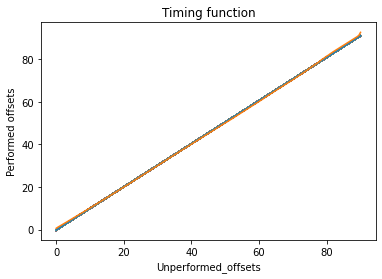

In [12]:
fig, ax = plt.subplots()
ax.plot(unperformed_annotations, pseudo_performed)
ax.plot(unperformed_annotations, performed_annotations[0])
ax.set_title('Timing function')
ax.set_ylabel('Performed offsets')
ax.set_xlabel('Unperformed_offsets')
fig.show()

/Users/ozaydin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


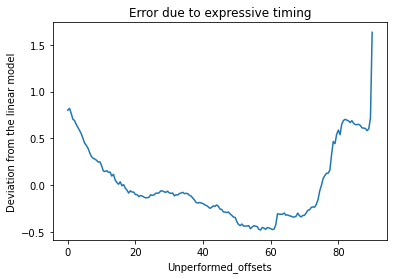

In [14]:
fig, ax = plt.subplots()
ax.plot(unperformed_annotations, err)
# ax.plot(unperformed_annotations, beats)
ax.set_title('Error due to expressive timing')
ax.set_ylabel('Deviation from the linear model')
ax.set_xlabel('Unperformed_offsets')
fig.show()

## Part B: Empirical Findings

In [22]:
import music21

In [23]:
def helpers_simplify_score_for_rhythm_analysis(sample_score_tmp):

    # remove chord charts, metronome mark, dynamics
    for part in sample_score_tmp.parts:
        for measure in part.getElementsByClass('Measure'):
            for event in measure:
                if isinstance(event, music21.harmony.ChordSymbol):
                    measure.remove(event)
                if isinstance(event, music21.tempo.MetronomeMark):
                    measure.remove(event)
                if isinstance(event, music21.dynamics.Dynamic):
                    measure.remove(event)
                if isinstance(event, music21.key.KeySignature):
                    measure.remove(event)

    # combine voice tracks intra-staff (done by extracted staffs and recombining)
    chordified_treble = sample_score_tmp.parts[0].chordify()
    chordified_bass = sample_score_tmp.parts[1].chordify()
    sample_score = music21.stream.Score()
    sample_score.insert(0, chordified_treble)
    sample_score.insert(0, chordified_bass)

    # cast all single-note chord objects (created by chordify) as note objects so students see more typical music21 score object structure
    staff_count = 0
    for part in sample_score.parts:
        staff_count += 1
        for measure in part.getElementsByClass('Measure'):
            for event in measure:
                if isinstance(event, music21.chord.Chord): # and len(event.notes) == 1:
                    note_version = music21.note.Note()
                    if staff_count == 1:
                        note_version.pitch = music21.pitch.Pitch('C4')
                    elif staff_count == 2:
                        note_version.pitch = music21.pitch.Pitch('C3')
                    note_version.duration = event.duration
                    start_found = 0
                    continue_found = 0
                    none_found = 0
                    all_ties_stop = 1
                    for nte in event.notes:
                        try:
                            curr_tie_obj = nte.tie.type
                        except:
                            curr_tie_obj = None
                        if (curr_tie_obj == 'start'):
                            start_found = 1
                        if (curr_tie_obj == 'continue'):
                            continue_found = 1
                        if (curr_tie_obj is None):
                            none_found = 1
                        if (curr_tie_obj != 'stop'):
                            all_ties_stop = 0
                    if start_found == 1:
                        note_version.tie = music21.tie.Tie('start')
                    elif none_found == 1:
                        note_version.tie = None
                    elif all_ties_stop == 1:
                        note_version.tie = music21.tie.Tie('stop')
                    elif continue_found == 1:
                        note_version.tie = music21.tie.Tie('continue')
                    note_version.offset = event.offset
                    note_version.articulations = event.articulations
                    note_version.expressions = event.expressions
                    measure.replace(event, note_version)

    # fix instances where tie start leads to tie None (should be no tie but previous loop isn't built to observe two consecutive elements)
    # the ties are a pain >:"{
    for part in sample_score.parts:
        for measure in part.getElementsByClass('Measure'):
            for i in range(len(measure)-1):
                curr_event = measure[i]
                next_event = measure[i+1]
                if isinstance(curr_event, music21.note.Note) and isinstance(next_event, music21.note.Note):
                    try:
                        curr_tie = curr_event.tie.type
                    except:
                        curr_tie = None
                    try:
                        next_tie = next_event.tie.type
                    except:
                        next_tie = None
                    if (curr_tie == 'start' or curr_tie == 'continue') and (next_tie == 'start' or next_tie is None):
                        measure[i].tie = music21.tie.Tie('stop')
                if isinstance(curr_event, music21.note.Rest):
                    measure[i].tie = None

    # combine tied notes intra-staff
    for part in sample_score.parts:
        active_tie = 0
        for measure in part.getElementsByClass('Measure'):
            for i in range(len(measure)):
                if isinstance(measure[i], music21.note.Note):
                    if measure[i].tie is not None:
                        if measure[i].tie.type == "start":
                            active_tie = 1
                        elif measure[i].tie.type == "stop" and active_tie == 1:
                            active_tie = 0
                        elif measure[i].tie.type == "stop" and active_tie == 0:
                            measure[i].tie = None

    treble = sample_score.parts[0]
    for measure in treble.getElementsByClass('Measure'):
        i = 0
        len_measure = len(measure)
        while i < len_measure-1:
            if isinstance(measure[i], music21.note.Note) and isinstance(measure[i+1], music21.note.Note):
                if measure[i].tie is not None and measure[i+1].tie is not None:
                    measure[i].duration = music21.duration.Duration(measure[i].duration.quarterLength + measure[i+1].duration.quarterLength)
                    if measure[i+1].tie is not None:
                        if measure[i+1].tie.type == "stop":
                            measure[i].tie = None
                    measure.remove(measure[i+1])
            i += 1
            len_measure = len(measure)

    bass = sample_score.parts[1]
    for measure in bass.getElementsByClass('Measure'):
        i = 0
        len_measure = len(measure)
        while i < len_measure-1:
            if isinstance(measure[i], music21.note.Note) and isinstance(measure[i+1], music21.note.Note):
                if measure[i].tie is not None and measure[i+1].tie is not None:
                    measure[i].duration = music21.duration.Duration(measure[i].duration.quarterLength + measure[i+1].duration.quarterLength)
                    if measure[i+1].tie is not None:
                        if measure[i+1].tie.type == "stop":
                            measure[i].tie = None
                    measure.remove(measure[i+1])
            i += 1
            len_measure = len(measure)

    sample_score = music21.stream.Score()
    sample_score.insert(0, treble)
    sample_score.insert(0, bass)

    # deciding against repeat expands for now due to issues with measure number

    return sample_score

### Compute note onsets on the metrical grid

In [24]:
def read_midi(path):
    # music21.midi.MidiFile.read(path)
    # return helpers_simplify_score_for_rhythm_analysis(music21.converter.parse(path))
    return music21.converter.parse(path)
    
def compute_offsets(midi):
    note_list_score = []
    note_list_measure = []
    note_list_measure3 = []
    for part in sample_score_tmp.parts:
        for measure in part.getElementsByClass('Measure'):
            for event in measure.getElementsByClass('Note'):
                offset_score = event.getOffsetInHierarchy(sample_score_tmp)
                offset_part = event.getOffsetInHierarchy(part)
                offset_measure = event.getOffsetInHierarchy(measure)
                # print(offset_score, offset_part, offset_measure)
                note_list_score.append(offset_score)
                
                if int(measure.duration.quarterLength*4) % 3 == 0:
                    note_list_measure3.append(offset_measure)
                else:
                    note_list_measure.append(offset_measure)
                
    score_offsets = np.array(note_list_score)
    measure_offsets = np.array(note_list_measure)
    measure_offsets3 = np.array(note_list_measure3)
    return score_offsets, measure_offsets, measure_offsets3

def compute_hist(offsets):
    unique, counts = np.unique(offsets, return_counts=True)
    return unique, counts

def plot_hist(unique, counts, title):
    fig, ax = plt.subplots()
    ax.bar(unique, counts, width=0.15)
    ax.set_title(title)
    ax.set_ylabel('# of notes')
    ax.set_xlabel('metric_location')
    fig.show()
    

/Users/ozaydin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


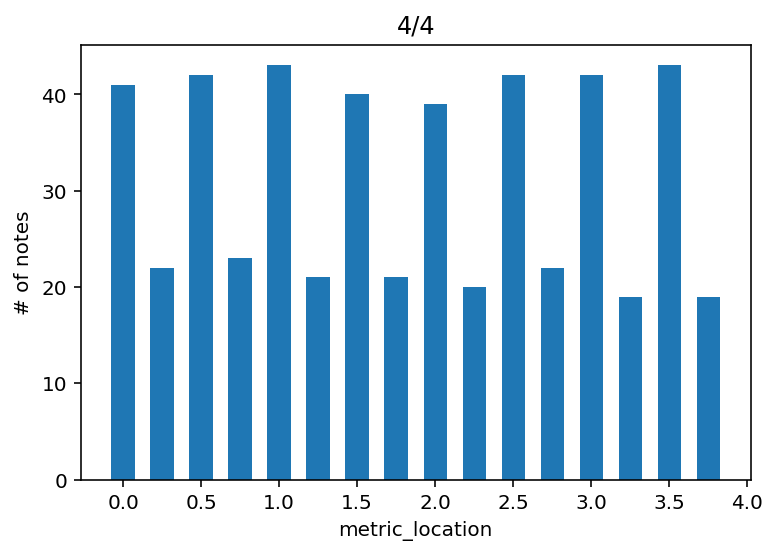

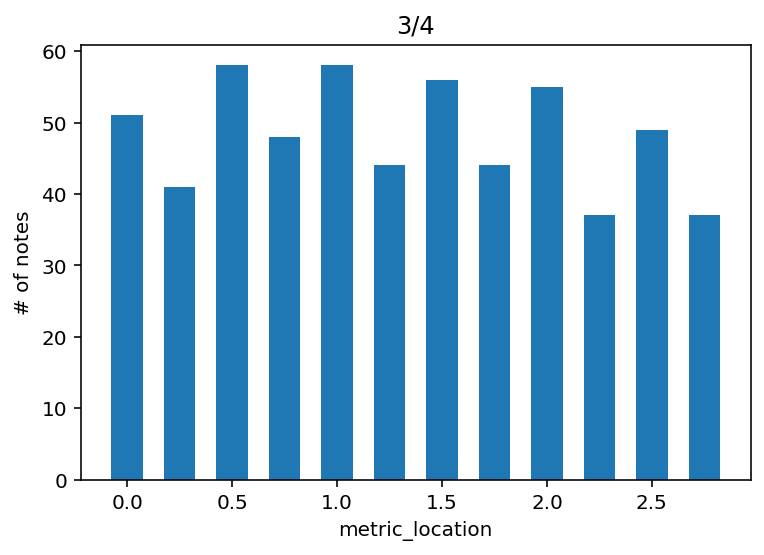

In [26]:
unperformed_midi = read_midi(unperformed_path.replace('_annotations.txt', '.mid'))
performed_midi = [read_midi(path.replace('_annotations.txt', '.mid')) for path in performer_paths]

sample_score_tmp = unperformed_midi

# for part in sample_score_tmp.parts:
#     for measure in part.getElementsByClass('Measure'):
#         for event in measure.getElementsByClass('Note'):
#             pass

score_offsets, measure_offsets, measure_offsets3 = compute_offsets(unperformed_midi)

unique, counts = compute_hist(measure_offsets)
unique3, counts3 = compute_hist(measure_offsets3)

plot_hist(unique, counts, '4/4')
plot_hist(unique3, counts3, '3/4')